In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

In [2]:
opsdb = db.OpsimDatabase('minion_1016_newsky.db')

In [3]:
simdata = opsdb.query_columns(opsdb.defaultTable, 
                              colnames=['fieldRA', 'fieldDec', 'filter', 'night', 'visitTime', 'airmass', 'filtSkyBrightness', 'expMJD'], 
                              sqlconstraint=None)

In [4]:
ra_array      = np.zeros(len(simdata))
dec_array     = np.zeros(len(simdata))
airmass_array = np.zeros(len(simdata))
time_array    = np.zeros(len(simdata))
night_array   = np.zeros(len(simdata))

# creating empty array for strings
val           = [''] * len(simdata)
filter_array  = np.array(val)

for i in range(len(simdata)):
    ra_array[i]      = simdata[i][0]
    dec_array[i]     = simdata[i][1]
    filter_array[i]  = simdata[i][2]
    night_array[i]   = simdata[i][3]
    time_array[i]    = simdata[i][7]#[4]
    airmass_array[i] = simdata[i][5]

In [5]:
import sncosmo
from   astropy.table    import Table
import numpy            as np
import matplotlib.pylab as plt
from   astropy.io       import ascii

In [6]:
filename = "/global/homes/a/anitab/DC2_run1p1_TransientDocs/Notebooks/Hosted_SN_table.csv"
from pandas import read_csv

In [7]:
vvv  = read_csv(filename)
data = vvv['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid']

In [ ]:
###vvv.columns

In [8]:
#### SN properties from sampled galaxies ####

length  = len(data)
zvals   = np.zeros(length) 
x0vals  = np.zeros(length)
x1vals  = np.zeros(length)
cvals   = np.zeros(length)
mBvals  = np.zeros(length)
t0vals  = np.zeros(length)
smass   = np.zeros(length)
ravals  = np.zeros(length)
decvals = np.zeros(length)

for i in range(length):
    zvals[i]   = data[i].split()[6]
    x0vals[i]  = data[i].split()[4]
    x1vals[i]  = data[i].split()[5]
    cvals[i]   = data[i].split()[1]
    mBvals[i]  = data[i].split()[2]
    t0vals[i]  = data[i].split()[3]
    smass[i]   = data[i].split()[20]
    ravals[i]  = data[i].split()[21]
    decvals[i] = data[i].split()[22]

### Choosing rows of OpSim based on sampled SNe

In [9]:
import os
import opsimsummary as oss
import healpy as hp
print(oss.__version__)

Some imports failed, which implies some dependencies are missing as described below
No module named 'mpl_toolkits.basemap'
Visulization functions based on maps will not work
1.16.1


In [10]:
from opsimsummary import SynOpSim

In [11]:
myopsimv3 = 'minion_1016_newsky.db'

In [12]:
synopsim = SynOpSim.fromOpSimDB(myopsimv3, opsimversion='lsstv3',
                                angleUnit='degrees', usePointingTree=True)

 reading from database sqlite:///minion_1016_newsky.db
SELECT * FROM Summary WHERE propID in (56, 54)


In [13]:
gen = synopsim.pointingsEnclosing(ravals, decvals, circRadius=0., pointingRadius=1.75, usePointingTree=True)

In [ ]:
#sum(1 for g in gen)
#len(ravals)
#len(rvals) should be equal to the suma above

In [ ]:
#df= next(gen)
#raopsim = df['fieldRA']

In [14]:
#raopsim_list  = []
#decopsim_list = []

timeopsim_list   = []
filteropsim_list = []

for i, df in enumerate(gen):
    #raopsim = df['fieldRA']
    #raopsim_list.append(raopsim.values)
    ###raopsim_list += raopsim.values.tolist()
    
    timeopsim = df['expMJD']
    timeopsim_list.append(timeopsim.values)
    
    filteropsim = df['filter']
    filteropsim_list.append(filteropsim.values)
    
    #decopsim = df['fieldDec']
    #decopsim_list.append(decopsim.values)

In [ ]:
#np.shape(raopsim_list)

In [ ]:
'''
ifx      = np.array([21,22,23,24,25]) # subplot numbers (for turning x ticks on/off)
ify      = np.array([1,6,11,16,21])

plt.figure(1, figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(np.rad2deg(decopsim_list[1000*i]), np.rad2deg(raopsim_list[1000*i]), ".", color="blue")
    plt.plot(decvals[1000*i], ravals[1000*i], ".", color="red")
    plt.ylim(50,60)
    plt.xlim(-34,-24)
    plt.tick_params(axis='both', labelleft='off', labelbottom='off')
    #plt.title("SN number {0}".format(1000*i))
    if i+1 in ifx:
        plt.xlabel("Ra [deg]",fontsize=15)
        plt.tick_params(axis='x', labelbottom='on')
    if i+1 in ify:
        plt.ylabel("Dec [deg]",fontsize=15)
        plt.tick_params(axis='y', labelleft='on')
    
plt.suptitle("SNe in red with opsim visits in blue")
'''

In [15]:
from lsst.sims.catUtils.supernovae import SNObject
def get_flux(i):
    params = {'x0': x0vals[i], 'x1': x1vals[i], 'c': cvals[i]}
    snobject = SNObject(ravals[i], decvals[i])
    snobject.set(**params)
    return snobject.catsimBandFlux(bandpassobject = filter_array[i], time=time_array[i])# time=t0vals[i])

In [26]:
mlist     = []
jlist_tot = []

for m in range(len(timeopsim_list)):
    jlist = []
    for j in range(len(timeopsim_list[m])):
        if (timeopsim_list[m][j] > t0vals[m] -19 and timeopsim_list[m][j] < t0vals[m] + 49):
            jlist.append(j)
    if jlist:
        mlist.append(m)
        jlist_tot.append(jlist)

In [36]:
from lsst.sims.photUtils.BandpassDict import BandpassDict
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()

In [119]:
# Going through each SN
fluxlist_tot = [] 
timelist_tot = []

for SN_id, val in enumerate(mlist[:50]):
    params   = {'x0': x0vals[val], 'x1': x1vals[val], 'c': cvals[val], 't0':t0vals[val]}
    snobject = SNObject(ravals[val], decvals[val])
    snobject.set(**params)
    
    filters_modified = [LSST_BandPass[key] for key in filteropsim_list[val]]

    fluxlist = []
    timelist = []
    
    for j in jlist_tot[SN_id]:
        fluxval = snobject.catsimBandFlux(bandpassobject = filters_modified[j], time = timeopsim_list[val][j])
        fluxlist.append(fluxval)
        timelist.append(timeopsim_list[val][j])
        
    
    fluxlist_tot.append(fluxlist)
    timelist_tot.append(timelist)

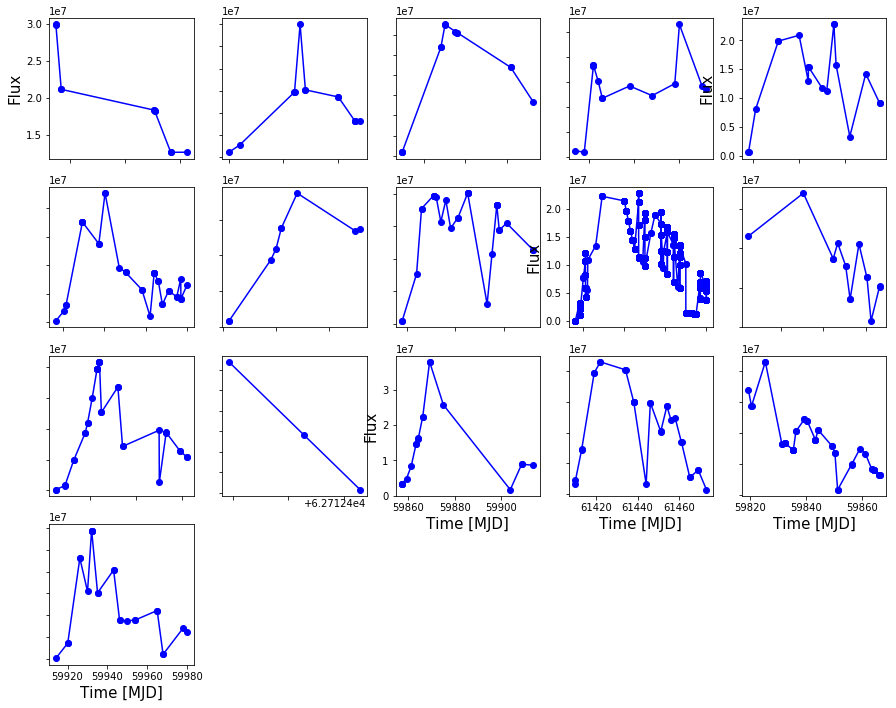

In [137]:
ifx      = np.array([13,14,15,16]) # subplot numbers (for turning x ticks on/off)
ify      = np.array([1,5,9,13])

plt.figure(1, figsize=(15,15))

for i in range(16):
    plt.subplot(5,5,i+1)
    
    indx = np.arange(0,len(timelist_tot[i]))
    Z = [x for _,x in sorted(zip(timelist_tot[i],indx))]
    
    plt.plot(np.sort(timelist_tot[i]), np.array(fluxlist_tot[i])[Z], "o", color='blue')
    plt.plot(np.sort(timelist_tot[i]), np.array(fluxlist_tot[i])[Z], color='blue')
    #plt.plot(timelist_tot[i], fluxlist_tot[i], ".")
    
    plt.tick_params(axis='both', labelleft='off', labelbottom='off')

    if i+1 in ifx:
        plt.xlabel("Time [MJD]",fontsize=15)
        plt.tick_params(axis='x', labelbottom='on')
    if i+1 in ify:
        plt.ylabel("Flux",fontsize=15)
        plt.tick_params(axis='y', labelleft='on')
    

In [ ]:
#t0s = t0vals
#for i, ops in enumerate(gen):
#    t0 = t0s[i]
#    x = ops.query('expMJD > @t0 - 60. and expMJD < @t0 + 90')
#    print ("done")

### LSST code example that works!

In [ ]:
bandpassnames = ['u', 'g', 'r', 'i', 'z', 'y']
from lsst.sims.photUtils.BandpassDict import BandpassDict
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()
SN = SNObject(ra=30., dec=-60.)
SN.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796112e-06)
SN.catsimBandFlux(bandpassobject=LSST_BandPass['r'], time=571190.)

In [ ]:
print(snobject)

In [ ]:
timeopsim_list[0]

In [ ]:
np.max(x0vals)/1e12

In [ ]:
def mB(x0):
    return 10.635 - (2.5 * np.log10(x0))

In [ ]:
mBvals = mB(x0vals/1e15)

In [ ]:
np.min(mBvals)

In [ ]:
np.max(mBvals)

In [ ]:
mB(1.796112e-06)

In [ ]:
filteropsim_list